# News headline topic analysis with Latent Dirichlet allocation (LDA)
The purpose of this analysis is to find dominant topics across news headlines (25 per day, over 1 year). These topics will later be correlated with daily stock market loss/gain information to understand how certain topics influence the stock market.

## What is LDA?
Latent Dirichlet allocation is a way to discover higher-level topics out of individual words present in any set of document (in our case, news headlines). You can use LDA to get a sense of the overall themes in a set of documents. 

LDA is an unsupervised machine learning model that works by analyzing two things: a distribution of topics in a document, and a distribution of words in a topic. The "topics" it finds aren't specific words (e.g., "This headline is about 'war'") but instead conceptually similar groups of words that together make up a theme (e.g., "This headline is similar to the words 'war', 'crisis', 'iran'...").

Once you've created your LDA model, you can feed in a document and the model will score the overall relevancy of your document against the main _x_ topics found in your overall corpus. In other words, it will tell you which of the main topics found in the overall corpus are also found in your document, and to what extent.

## Why LDA?
LDA is a fairly popular topic modelling choice among NLP professionals, and relatively straightforward to implement. Using LDA, we were able to find 10 dominant themes in eight years' worth of news headlines within about an hour—a task that would take a human days to analyze.

## How does text pre-processing affect the accuracy of LDA?
We tested two pre-processing approaches: Bag of Words and TF-IDF, each of which count how often words appear in a document. The TF-IDF model tries to understand which words are more important than others in a document, and scores them accordingly. The assumption was that TF-IDF preprocessing will help train a more accurate LDA model, but that did not turn out to be true; Bag of Words performed better.

## How does LDA perform compared to other topic models?
LDA appears to perform more poorly than an NMF model on assigning topics to headline text, when topics are reviewed by humans. However, LDA topics perform _better_ in our regression analyses and neural network models, when used as features to predict stock market gains and losses.

## Credit
Parts of this work borrow from excellent Susan Li's ["Topic Modeling and LDA in Python"](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24) tutorial.

# Load the data from CSV, dependencies

In [2]:
# import dependencies
import pandas as pd

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import numpy as np
import random
np.random.seed(22)

import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /Users/stacy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Import the data
data = pd.read_csv("../Data/RedditNews.csv")

In [4]:
data.head()

# 73,608 records from 2016-2018

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [5]:
# Getting just the headlines for our corpus
headlines = data[['News']]
headlines.head()

,News
0,A 117-year-old woman in Mexico City finally re...
1,IMF chief backs Athens as permanent Olympic host
2,"The president of France says if Brexit won, so..."
3,British Man Who Must Give Police 24 Hours' Not...
4,100+ Nobel laureates urge Greenpeace to stop o...


# Data pre-processing
## Lemmitize
In order to properly identify topics, we need to standardize the words in some way, removing extraneous information like tenses or plurals (e.g. "running", "runs" -> "run"). Lemmatization is the best way to do that, although it's not always the fastest way. In some cases, stemming will also work, althought it is not as precise.

Since we have a relatively small corpus to study, we will use lemmatization in order to be as precise as possible when cleaning up the words. To do this, we will feed in a `pos` parameter that tells our lemmatizing function to perform stemming with context.

Natural Language Toolkit's `stem` package includes a handy function called `WordNetLemmatizer` that makes lemmatizing our words simple. 

In [6]:
# Lemmatize the words keeping the context (stemming is "dumb" so we won't)
# However if we have a much larger corpus, we might consider stemming (as it is faster)
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v') # pos='v' means it peforms stemming with context

## Remove stopwords and words shorter than 3 chars
We also need to remove common words that don't add value ("a", "the", etc). These are called _stopwords_, and most NLP libraries have built-in methods for dealing with them. In `gensim`, the stopwords list can be called using `gensim.parsing.preprocessing.STOPWORDS`.

In [7]:
# Remove stopwords and words shorter than 3 characters, then lemmatize
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return result

## Check outputs
Let's compare the regular version of a sample headlind with the tokenized and lemmatized version. You'll note they are slightly different, but retain the same context.

In [8]:
sample = headlines['News'][2]

print('original document: ')
words = []
for word in sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(sample))

original document: 
['The', 'president', 'of', 'France', 'says', 'if', 'Brexit', 'won,', 'so', 'can', 'Donald', 'Trump']


 tokenized and lemmatized document: 
['president', 'france', 'say', 'brexit', 'donald', 'trump']


## Preprocess the headlines and save the results
Now we feed all the headlines into the preprocessing function, which lemmatizes and removes stopwords. 

In [9]:
cleaned_headlines = headlines['News'].map(preprocess)
print(cleaned_headlines[:5]) # Check the results
sample_size = cleaned_headlines.shape[0]

0    [year, woman, mexico, city, finally, receive, ...
1      [chief, back, athens, permanent, olympic, host]
2      [president, france, say, brexit, donald, trump]
3    [british, police, hours, notice, threaten, hun...
4    [nobel, laureates, urge, greenpeace, stop, opp...
Name: News, dtype: object


In [10]:
sample_size

73608

## Count the word occurences using Bag of Words
We can count the words using different approaches. Bag of Words will simply count all remaining words left in our corpus.

In [11]:
# First we need to convert the words to numeric indices. We can do that with a gensim Dictionary.

# corpora.Dictionary implements the concept of a Dictionary – a mapping between words and their integer ids.
# https://radimrehurek.com/gensim/corpora/dictionary.html

dictionary = gensim.corpora.Dictionary(cleaned_headlines)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 alvarez
1 bear
2 birth
3 certificate
4 city
5 die
6 finally
7 hours
8 later
9 lira
10 mexico


In [12]:
'''
Filter out irrelevant words:
Keep tokens that appear in at least 15 documents
Keep only the 100,000 most frequent tokens
'''

dictionary.filter_extremes(no_below=15, keep_n=100000)

In [13]:
'''
Apply `doc2bow` to each headline, which createst a Bag of Words dictionary that reports how many words 
are in the headline and how many times each word appears.

Save this to an array, then check the example headline from above.
'''

bow_corpus = [dictionary.doc2bow(headline) for headline in cleaned_headlines]
print(bow_corpus[2])

bow_doc_2 = bow_corpus[2]

for i in range(len(bow_doc_2)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2[i][0], 
                                            dictionary[bow_doc_2[i][0]], 
                                            bow_doc_2[i][1]))

[(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]
Word 21 ("brexit") appears 1 time.
Word 22 ("donald") appears 1 time.
Word 23 ("france") appears 1 time.
Word 24 ("president") appears 1 time.
Word 25 ("say") appears 1 time.
Word 26 ("trump") appears 1 time.


## Count the word occurences using TF-IDF
We'll also test whether TF-IDF works better than Bag of Words for creating a corpus that, when fed into our LDA model, will produce coherent and accurate topics. 

In `gensim`, TF-IDF builds on Bag of Words, taking in processed BoW corpus data and returning a number that reflects how important a word is to each headline in the overall corpus. Conversely, the scikit-learn implementation of TF-IDF handles this all in one step.

In [14]:
from gensim import corpora, models

# Create the model
tfidf = models.TfidfModel(bow_corpus)

# Feed in the BoW corpus to the TF-IDF model
corpus_tfidf = tfidf[bow_corpus]

# Print the same headline from above
corpus_tfidf[2]

[(21, 0.5271930944921088),
 (22, 0.5289685708527566),
 (23, 0.3076906708092066),
 (24, 0.25211992539378436),
 (25, 0.18133987533447585),
 (26, 0.5011362450471095)]

## Running LDA using Bag of Words
We'll first run `LdaMulticore` using our `bow_corpus` and limiting our number of topics to 10. We're also going to print out the resulting topics and how the dominant words score in each topic. The parameter `id2word` helps us pass the numeric indices in our dictionary back into human-readable words.

In [15]:
# We'll first split the dataset into a random sample containing 90% of documents.

bow_sample = random.sample(bow_corpus, int(sample_size*.9))

# We have to play around with how many passes to take over the corpus in order to make the topics coherent
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2)

In [16]:
# Print each topic and how the words in those topics score (their relative weight)
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.029*"israel" + 0.022*"china" + 0.016*"iran" + 0.014*"state" + 0.013*"say" + 0.012*"attack" + 0.009*"world" + 0.009*"right" + 0.009*"human" + 0.008*"nuclear"
Topic: 1 
Words: 0.012*"bank" + 0.010*"government" + 0.009*"court" + 0.008*"million" + 0.007*"police" + 0.007*"china" + 0.007*"billion" + 0.007*"say" + 0.006*"chinese" + 0.006*"world"
Topic: 2 
Words: 0.031*"kill" + 0.018*"attack" + 0.014*"force" + 0.012*"bomb" + 0.010*"soldier" + 0.008*"army" + 0.008*"state" + 0.008*"taliban" + 0.008*"syria" + 0.008*"syrian"
Topic: 3 
Words: 0.023*"north" + 0.022*"korea" + 0.021*"kill" + 0.018*"south" + 0.013*"pakistan" + 0.010*"strike" + 0.009*"say" + 0.008*"people" + 0.008*"death" + 0.008*"year"
Topic: 4 
Words: 0.027*"israel" + 0.025*"gaza" + 0.013*"israeli" + 0.012*"palestinian" + 0.010*"ship" + 0.009*"hamas" + 0.008*"right" + 0.008*"west" + 0.008*"say" + 0.007*"report"
Topic: 5 
Words: 0.010*"world" + 0.010*"india" + 0.007*"power" + 0.007*"water" + 0.007*"years" + 0.007*"pl

## Running LDA using TF-IDF
We'll run the same LDA model on the corpus processed using TF-IDF, to see if the topics generated here are any more meaningful. We'll use the same other parameters in our `LdaMulticore` model, for consistency.

In [17]:
# Get random sample of tf_idf corpus
corpus_tfidf.corpus

tfidf_sample = random.sample(corpus_tfidf.corpus, int(sample_size*.9))

lda_model_tfidf = gensim.models.LdaMulticore(tfidf_sample, num_topics=10, id2word=dictionary, passes=2)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.026*"korea" + 0.025*"north" + 0.014*"russia" + 0.012*"south" + 0.011*"nuclear" + 0.009*"korean" + 0.009*"say" + 0.008*"world" + 0.007*"japan" + 0.007*"weapons"
Topic: 1 Word: 0.011*"wikileaks" + 0.010*"say" + 0.008*"death" + 0.008*"case" + 0.007*"government" + 0.006*"document" + 0.006*"iran" + 0.005*"assange" + 0.005*"russia" + 0.004*"people"
Topic: 2 Word: 0.030*"china" + 0.010*"power" + 0.010*"water" + 0.009*"billion" + 0.008*"world" + 0.008*"say" + 0.007*"japan" + 0.006*"energy" + 0.006*"report" + 0.006*"million"
Topic: 3 Word: 0.038*"kill" + 0.013*"attack" + 0.013*"police" + 0.011*"saudi" + 0.010*"women" + 0.009*"protest" + 0.009*"say" + 0.009*"pakistan" + 0.009*"arrest" + 0.007*"people"
Topic: 4 Word: 0.008*"news" + 0.008*"government" + 0.008*"pirate" + 0.006*"say" + 0.006*"year" + 0.006*"strike" + 0.006*"vatican" + 0.006*"abuse" + 0.006*"call" + 0.005*"children"
Topic: 5 Word: 0.023*"israeli" + 0.013*"israel" + 0.012*"palestinian" + 0.011*"say" + 0.010*"gaza" + 0

## Compare the performance of the two preprocessing steps in the LDA model

In [18]:
# our test headline from above
cleaned_headlines[2] # human-readable version of bow_corpus[2]

['president', 'france', 'say', 'brexit', 'donald', 'trump']

### Bag of Words LDA model scores

In [19]:
for index, score in sorted(lda_model_bow[bow_corpus[2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_bow.print_topic(index, 10)))


Score: 0.8713578581809998	 
Topic: 0.010*"say" + 0.009*"government" + 0.008*"election" + 0.008*"vote" + 0.007*"saudi" + 0.007*"country" + 0.006*"party" + 0.006*"drug" + 0.006*"european" + 0.006*"leave"

Score: 0.014297340996563435	 
Topic: 0.011*"government" + 0.009*"internet" + 0.007*"israeli" + 0.007*"muslim" + 0.007*"say" + 0.006*"protest" + 0.006*"president" + 0.006*"people" + 0.005*"right" + 0.005*"house"

Score: 0.014294545166194439	 
Topic: 0.023*"police" + 0.011*"russian" + 0.010*"president" + 0.009*"year" + 0.008*"woman" + 0.007*"russia" + 0.007*"shoot" + 0.007*"putin" + 0.007*"protest" + 0.006*"tell"

Score: 0.014294018968939781	 
Topic: 0.023*"iran" + 0.015*"russia" + 0.015*"iraq" + 0.014*"world" + 0.012*"nuclear" + 0.008*"china" + 0.007*"say" + 0.006*"obama" + 0.006*"missile" + 0.006*"troop"

Score: 0.014293573796749115	 
Topic: 0.031*"kill" + 0.018*"attack" + 0.014*"force" + 0.012*"bomb" + 0.010*"soldier" + 0.008*"army" + 0.008*"state" + 0.008*"taliban" + 0.008*"syria" + 

### TF-IDF LDA model scores

In [20]:
for index, score in sorted(lda_model_tfidf[bow_corpus[2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index)))


Score: 0.5759003162384033	 
Topic: 0.023*"israeli" + 0.013*"israel" + 0.012*"palestinian" + 0.011*"say" + 0.010*"gaza" + 0.009*"iran" + 0.008*"bank" + 0.008*"attack" + 0.007*"house" + 0.007*"protest"

Score: 0.3097584843635559	 
Topic: 0.026*"korea" + 0.025*"north" + 0.014*"russia" + 0.012*"south" + 0.011*"nuclear" + 0.009*"korean" + 0.009*"say" + 0.008*"world" + 0.007*"japan" + 0.007*"weapons"

Score: 0.014296481385827065	 
Topic: 0.033*"israel" + 0.012*"gaza" + 0.008*"israeli" + 0.007*"anti" + 0.006*"hamas" + 0.006*"president" + 0.006*"attack" + 0.006*"world" + 0.005*"block" + 0.005*"internet"

Score: 0.014296040870249271	 
Topic: 0.014*"state" + 0.013*"putin" + 0.013*"president" + 0.012*"say" + 0.012*"drug" + 0.011*"police" + 0.011*"islamic" + 0.008*"russia" + 0.006*"india" + 0.006*"russian"

Score: 0.01429192628711462	 
Topic: 0.038*"kill" + 0.013*"attack" + 0.013*"police" + 0.011*"saudi" + 0.010*"women" + 0.009*"protest" + 0.009*"say" + 0.009*"pakistan" + 0.009*"arrest" + 0.007*"

Both approaches have relatively high accuracy with classification (> .80), and mostly make sense when reviewed by a human. What if we predicted topics for a headline that does not appear in our training set?

### Testing models on a new headline
When using an unseen headline, the Bag of Words-trained LDA model appears to classify the headline's topic more accurately.

* Bag of Words top topic: `Topic: 0.023*"iran" + 0.015*"russia" + 0.015*"iraq" + 0.014*"world" + 0.012*"nuclear"`
* TF-IDF top topic: `Topic: 0.012*"say" + 0.011*"government" + 0.007*"call" + 0.007*"pope" + 0.006*"party"`

In [21]:
unseen_document = 'Trump finally broke with Fauci'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("BoW approach\n")
for index, score in sorted(lda_model_bow[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_bow.print_topic(index, 5)))
    
print("\nTF-IDF approach")
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

BoW approach

Score: 0.486767053604126	 Topic: 0.023*"iran" + 0.015*"russia" + 0.015*"iraq" + 0.014*"world" + 0.012*"nuclear"
Score: 0.31312739849090576	 Topic: 0.010*"say" + 0.009*"government" + 0.008*"election" + 0.008*"vote" + 0.007*"saudi"
Score: 0.02501699887216091	 Topic: 0.023*"police" + 0.011*"russian" + 0.010*"president" + 0.009*"year" + 0.008*"woman"
Score: 0.02501552551984787	 Topic: 0.012*"bank" + 0.010*"government" + 0.009*"court" + 0.008*"million" + 0.007*"police"
Score: 0.025015123188495636	 Topic: 0.011*"government" + 0.009*"internet" + 0.007*"israeli" + 0.007*"muslim" + 0.007*"say"
Score: 0.025013510137796402	 Topic: 0.029*"israel" + 0.022*"china" + 0.016*"iran" + 0.014*"state" + 0.013*"say"
Score: 0.025011902675032616	 Topic: 0.027*"israel" + 0.025*"gaza" + 0.013*"israeli" + 0.012*"palestinian" + 0.010*"ship"
Score: 0.025011325255036354	 Topic: 0.023*"north" + 0.022*"korea" + 0.021*"kill" + 0.018*"south" + 0.013*"pakistan"
Score: 0.025010893121361732	 Topic: 0.031*"ki

## Export the model
We'll use the LDA-Bag of words model, which appears to be more accurate (based on our test documents).

In [22]:
import joblib
joblib.dump(lda_model_bow, "lda_bow.gz")

['lda_bow.gz']

## Append topics and scores to cleaned dataset

In [23]:
# This function returns the best-scoring topic and score assocated with a headline
def topic_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        return topic

topic_getter(unseen_document)

7

In [24]:
# Load dataset with combined data
all_data = pd.read_csv('../Data/Combined_News_DJIA.csv')
all_data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [25]:
all_data.dropna(how='any', inplace=True)

In [26]:
# Loop through the columns containing headlines and apply `topic_getter` to each headline, to retrieve topic
# Assign that data to a new column

for x in range(1,26): # for each column
    col = "Top" + str(x)
    new_col = col + "_topic"
    
    # for each row in column
    # get the headline, feed it into the lda_model_bow to get the topic and score
    all_data[new_col] = all_data[col].apply(topic_getter)

In [27]:
# Check the output
all_data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16_topic,Top17_topic,Top18_topic,Top19_topic,Top20_topic,Top21_topic,Top22_topic,Top23_topic,Top24_topic,Top25_topic
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,6,2,0,7,2,7,6,2,8,2
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,0,6,6,0,9,2,6,4,7,5
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,6,6,0,6,1,4,6,9,9,5
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,3,7,4,4,0,0,7,4,4,6
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,0,0,4,4,6,9,2,4,2,2


In [28]:
# Save updated data
all_data.to_csv("../Data/Combined_News_DJIA_topics.csv")

# Find one dominant topic per day

In [30]:
single_topic = all_data
del all_data # Removing now that unneeded to improve performance

In [31]:
# Drop unnecessary columns from prev dataframe
cols = []
for x in range(1,26):
    cols.append("Top" + str(x) + "_topic")  

single_topic.drop(axis=1, labels=cols, inplace=True)
single_topic.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [32]:
# Combine, clean single_topic headlines 
single_topic.loc[:,'combined_headlines'] = single_topic.loc[:,'Top1'] + " " + single_topic.loc[:,'Top2'] \
                                        + " " + single_topic.loc[:,'Top3'] + " " + single_topic.loc[:,'Top4'] \
                                        + " " + single_topic.loc[:,'Top5'] + " " + single_topic.loc[:,'Top6'] \
                                        + " " + single_topic.loc[:,'Top7'] + " " + single_topic.loc[:,'Top8'] \
                                        + " " + single_topic.loc[:,'Top9'] + " " + single_topic.loc[:,'Top10'] \
                                        + " " + single_topic.loc[:,'Top11'] + " " + single_topic.loc[:,'Top12'] \
                                        + " " + single_topic.loc[:,'Top13'] + " " + single_topic.loc[:,'Top14'] \
                                        + " " + single_topic.loc[:,'Top15'] + " " + single_topic.loc[:,'Top16'] \
                                        + " " + single_topic.loc[:,'Top17'] + " " + single_topic.loc[:,'Top18'] \
                                        + " " + single_topic.loc[:,'Top19'] + " " + single_topic.loc[:,'Top20'] \
                                        + " " + single_topic.loc[:,'Top21'] + " " + single_topic.loc[:,'Top22'] \
                                        + " " + single_topic.loc[:,'Top23'] + " " + single_topic.loc[:,'Top24'] \
                                        + " " + single_topic.loc[:,'Top25']

single_topic.loc[:,'combined_headlines'] = single_topic.loc[:,'combined_headlines'].str.replace('b[\'\"]', ' ')
single_topic.dropna(how='any', inplace=True)

cleaned_all_headlines = single_topic['combined_headlines'].map(preprocess)

single_topic.iloc[905,:]

Date                                                         2012-03-16
Label                                                                 0
Top1                  Chinese official proposes death penalty as det...
Top2                  New Chevron Oil Leak Off Coast of Brazil - Jus...
Top3                    Shell admits to at least 207 oil spills in 2011
Top4                  A Jewish man wins his fight against a German m...
Top5                  UK would not help Israel attack Iran, Prime Mi...
Top6                  "Afghan President Hamid Karzai lashed out at t...
Top7                  Putin's Fabled Tiger Encounter was PR Stunt, S...
Top8                  Moroccans call for end to rape-marriage laws -...
Top9                  Friends no more? Egypts MPs declare Israel No....
Top10                 In emails, the nuclear physicist at one of Eur...
Top11                 Syrian armed forces desertion said to surge to...
Top12                 A Moroccan government minister on Thursday

In [33]:
# Count word occurences using Bag of Words on new cleaned_headlines
dictionary = gensim.corpora.Dictionary(cleaned_all_headlines)

In [34]:
'''
Filter out irrelevant words:
Keep tokens that appear in at least 15 documents
Keep only the 100,000 most frequent tokens
'''

dictionary.filter_extremes(no_below=15, keep_n=100000)

In [35]:
'''
Apply `doc2bow` to each headline, which createst a Bag of Words dictionary that reports how many words 
are in the headline and how many times each word appears.

Save this to an array, then check the example headline from above.
'''


bow_corpus = [dictionary.doc2bow(headline) for headline in cleaned_all_headlines]
print(bow_corpus[2])

bow_doc_2 = bow_corpus[2]

for i in range(len(bow_doc_2)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2[i][0], 
                                            dictionary[bow_doc_2[i][0]], 
                                            bow_doc_2[i][1]))

[(12, 1), (13, 1), (15, 1), (21, 1), (30, 1), (33, 10), (34, 4), (42, 1), (44, 1), (45, 1), (47, 1), (58, 1), (59, 3), (62, 2), (63, 1), (65, 1), (66, 1), (67, 2), (68, 3), (78, 1), (83, 5), (84, 2), (94, 4), (95, 1), (103, 2), (106, 1), (111, 1), (121, 1), (125, 1), (136, 1), (139, 2), (199, 1), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 1), (207, 1), (208, 1), (209, 1), (210, 1), (211, 1), (212, 1), (213, 1), (214, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 1), (221, 1), (222, 1), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 2), (230, 2), (231, 1), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1), (237, 1), (238, 1), (239, 2), (240, 1), (241, 1), (242, 1), (243, 1), (244, 1), (245, 1), (246, 1), (247, 1), (248, 1), (249, 1), (250, 1), (251, 1), (252, 1), (253, 1), (254, 1), (255, 2), (256, 1), (257, 2), (258, 1), (259, 1), (260, 1), (261, 1), (262, 1), (263, 1), (264, 1), (265, 1), (266, 1), (267, 1), (268, 1), (269, 1), (2

In [36]:
# Run new BoW data through LDA model

'''
NOTE: Run this on a machine with lots of processing power, or as a Google Colab notebook. Otherwise it might
take a really long time to run! TODO: Refactor this notebook to optimize performance so it can be run locally.
'''

bow_sample = random.sample(bow_corpus, int(cleaned_all_headlines.shape[0]*.9))

lda_model_bow = gensim.models.LdaMulticore(bow_sample, num_topics=10, id2word=dictionary, passes=2)

In [37]:
# Print each topic and how the words in those topics score (their relative weight)
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.004*"president" + 0.004*"time" + 0.003*"force" + 0.003*"isis" + 0.003*"protest" + 0.003*"north" + 0.003*"plan" + 0.003*"syria" + 0.003*"minister" + 0.003*"bank"
Topic: 1 
Words: 0.006*"russian" + 0.005*"russia" + 0.004*"million" + 0.004*"force" + 0.004*"president" + 0.004*"military" + 0.003*"syria" + 0.003*"protest" + 0.003*"group" + 0.003*"call"
Topic: 2 
Words: 0.007*"russia" + 0.004*"japan" + 0.003*"president" + 0.003*"country" + 0.003*"korea" + 0.003*"power" + 0.003*"time" + 0.003*"russian" + 0.003*"call" + 0.003*"military"
Topic: 3 
Words: 0.006*"russia" + 0.004*"iran" + 0.004*"military" + 0.004*"north" + 0.004*"korea" + 0.004*"force" + 0.004*"right" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"
Topic: 4 
Words: 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"
Topic: 5 
Words: 0.005*"force" + 0.005*"india" + 0.005*"russian" + 0.005*"rus

In [38]:
# Test new model on unseen dataset
unseen_document = 'Trump finally broke with Fauci'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("BoW approach\n")
for index, score in sorted(lda_model_bow[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_bow.print_topic(index, 10)))
    
# This has a higher accuracy score than the per-headline topic analysis above

BoW approach

Score: 0.7748267650604248	 Topic: 0.004*"president" + 0.004*"time" + 0.003*"force" + 0.003*"isis" + 0.003*"protest" + 0.003*"north" + 0.003*"plan" + 0.003*"syria" + 0.003*"minister" + 0.003*"bank"
Score: 0.025022020563483238	 Topic: 0.007*"israeli" + 0.007*"gaza" + 0.005*"right" + 0.004*"iran" + 0.004*"time" + 0.004*"news" + 0.004*"country" + 0.004*"arrest" + 0.003*"president" + 0.003*"force"
Score: 0.02502046711742878	 Topic: 0.005*"russia" + 0.004*"bank" + 0.004*"president" + 0.004*"force" + 0.004*"time" + 0.003*"death" + 0.003*"plan" + 0.003*"snowden" + 0.003*"military" + 0.003*"right"
Score: 0.025020290166139603	 Topic: 0.005*"israeli" + 0.005*"iran" + 0.004*"gaza" + 0.004*"russia" + 0.004*"minister" + 0.004*"nuclear" + 0.004*"right" + 0.003*"call" + 0.003*"want" + 0.003*"court"
Score: 0.025020089000463486	 Topic: 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" +

In [39]:
# This function returns the best-scoring topic and score assocated with a headline
def topic_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        return topic
    
def word_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        return lda_model_bow.print_topic(topic, 10)    

# Test to confirm it still returns the topic for a particular headline
topic_getter(unseen_document)
word_getter(unseen_document)

'0.007*"israeli" + 0.007*"gaza" + 0.005*"right" + 0.004*"iran" + 0.004*"time" + 0.004*"news" + 0.004*"country" + 0.004*"arrest" + 0.003*"president" + 0.003*"force"'

In [40]:
# Create a combined function to test our testing dataset against    

population = 1986

def test_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        # Print a headline snippet and the topic so we can visually compare each headline set against the assigned topic
        print(f"headline: {headline[0:300]}\n\n topic: {str(topic)} {lda_model_bow.print_topic(topic, 10)}\n\n")    

# Create a random sample of 20% of our overall document set        
sample_series = random.sample(list(single_topic['combined_headlines']), int(population*.2))

for headline in sample_series:
    test_getter(headline)

headline:  Church of Scientology in Sydney accused of holding a young Taiwanese woman hostage Rats trained to detect mines find 2400 landmines in Mozambique. North Korea expanding gulags, satellite images show As its vice president, the UN Human Rights Council has chosen as Mauritania  "a country that allows 

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Europe is considering a sweeping new law that would force Internet companies like Amazon.com and Facebook to obtain explicit consent from consumers about the use of their personal data, delete that data forever at the consumers request and face fines for failing to comply. Forced Sterilization for T

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: 

headline: Terror laws clear Senate, enabling entire Australian web to be monitored and whistleblowers to be jailed UAEs first female fighter pilot likely dropping bombs on ISIS militants in Syria [now confirmed] The European Space Agency's satellite array dubbed Swarm revealed that Earth's magnetic field is w

 topic: 0 0.004*"president" + 0.004*"time" + 0.003*"force" + 0.003*"isis" + 0.003*"protest" + 0.003*"north" + 0.003*"plan" + 0.003*"syria" + 0.003*"minister" + 0.003*"bank"


headline:  The outbreak of swine flu should be renamed "Mexican" influenza in deference to Muslim and Jewish sensitivities over pork, said an Israeli health official Monday.'  'Panic Can Spread More Quickly Than Swine Flu'"  First the swine flu, now an earthquake. Mexico City is doomed!'  British Government P

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline:  Did Saa

headline: North Korea slashes food rations to 150 grams of rice per day.  One hundred grams of rice produces about 250-350 calories BBC News- Stabbing burglars 'will be legal' Iceland Declares Independence from International Banks Russia cuts off power to Belarus Police forces can no longer put anyone out on 

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline:  "In a crowded civilian city, there are all sorts of people who cannot run away: the elderly, the disabled, the pregnant, the terrified. This soldier was told to kill them."'  Obama address the Iranian People'  Depression-era law lets Iowa turkey farm pay mentally retarded workers 37 cents an hour' 

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: 

headline:  Iceland. Sept 5/08 : UN's Best Country to Live '07.  Oct 5/08: Food hoarding begins, Currency rated just above Zimbabwe"  The dark side of Dubai'  China cancels military contacts with US in protest '  Pirates die mysteriously on captured ship'  Pakistan facing bankruptcy '  Taliban split with al Qa

 topic: 8 0.006*"north" + 0.005*"korea" + 0.004*"right" + 0.004*"death" + 0.003*"court" + 0.003*"time" + 0.003*"wikileaks" + 0.003*"iran" + 0.003*"nuclear" + 0.003*"military"


headline: Opposition ballots found in trash bags in southern Turkey Mexican marines kill leader of Knights Templar drug cartel Saudi Arabia Doubles Down on Atheism; New Laws Declares It Equivalent to Terrorism -- "non-believers are assumed to be enemies of the Saudi state" Lithuania bans Russian TV station ov

 topic: 3 0.006*"russia" + 0.004*"iran" + 0.004*"military" + 0.004*"north" + 0.004*"korea" + 0.004*"force" + 0.004*"right" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"


headline: British ISIS

headline: Thousands of UK Workers 'Blacklisted' Over Political Views. Corporations in the UK used a secret "blacklisting" database to screen out left wing trouble-makers and union sympathizers as potential job recruits. Ireland abandoning religion faster than almost every other country Pharma giant Pfizer fin

 topic: 0 0.004*"president" + 0.004*"time" + 0.003*"force" + 0.003*"isis" + 0.003*"protest" + 0.003*"north" + 0.003*"plan" + 0.003*"syria" + 0.003*"minister" + 0.003*"bank"


headline: Good News. Tiger Numbers in India up From 1,400 to 2,226 in 7 Years Iranian newspaper shut down for showing solidarity with Charlie Hebdo Pope says birth control ban doesn't mean breed 'like rabbits' Kenya police tear-gas school kids protesting the removal of playground Hundreds of anonymous Wikiped

 topic: 3 0.006*"russia" + 0.004*"iran" + 0.004*"military" + 0.004*"north" + 0.004*"korea" + 0.004*"force" + 0.004*"right" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"


headline: 'People are be

headline: Billionaire dies and leaves $3.3 billion to charity 'Many dead' in Ukraine offensive, rebels killed, injured and arrested in Ukraine offensive Neo-Nazis spark first church alarm since WWII: The churches in Jnkping, Sweden, rang their bells in warning for two hours on May Day as neo-Nazis took to the

 topic: 3 0.006*"russia" + 0.004*"iran" + 0.004*"military" + 0.004*"north" + 0.004*"korea" + 0.004*"force" + 0.004*"right" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"


headline: Pirate Bay Founders Acquitted in Criminal Copyright Case BMW has just put the first 100% all electric 18 wheeler out on the road in Germany Pope Francis warns against new forms of colonialism: "Human beings and nature must not be at the service of money. Let us say no to an economy of exclusion and 

 topic: 0 0.004*"president" + 0.004*"time" + 0.003*"force" + 0.003*"isis" + 0.003*"protest" + 0.003*"north" + 0.003*"plan" + 0.003*"syria" + 0.003*"minister" + 0.003*"bank"


headline:  Dubai in Deep

headline: Irish college students had 36 hrs to get as far as they could in the world, without spending any money. Some reached Argentina, Australia and Malaysia. New Zealand gay marriage bill passes North Korean Desertion Skyrocketing, Number of NK Military AWOL Shoots Up Eightfold Assassination attempt of Ki

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Indian Govt. planning to make 50 essential medicines free of cost for every citizen from birth to death. Doctors without Borders say that "the Ebola outbreak ravaging West Africa is 'totally out of control'" and "the outbreak is far from over and will probably end up as the most deadly on record." W

 topic: 9 0.005*"russia" + 0.004*"bank" + 0.004*"president" + 0.004*"force" + 0.004*"time" + 0.003*"death" + 0.003*"plan" + 0.003*"snowden" + 0.003*"military" + 0.003*"right"


headline: China:

headline: Apple Continues To Insist Only It Can Use An Apple In A Logo; Threatens Small German Cafe London's Metropolitan Police discovers existence of a secret mobile phone within News International's east London HQ that was used in more than 1,000 incidents of illegal hacking A top US government official be

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Tiny island nation that controls vast area of Pacific Ocean bans all commercial fishing in one of world's largest marine parks - "If you think of the ocean as a bank account in which everybody withdraws but nobody makes a deposit, then protected marine reserves are like savings with interest." Brita

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: 

headline: Irish no-frills airline Ryanair confirmed its board has approved plans to start flying low-cost transatlantic routes starting from $14 in the next five years. Strip-searched girl can't return to her school, Quebec judge rules . In the strip search, the girl was asked to remove all her clothing, incl

 topic: 2 0.007*"russia" + 0.004*"japan" + 0.003*"president" + 0.003*"country" + 0.003*"korea" + 0.003*"power" + 0.003*"time" + 0.003*"russian" + 0.003*"call" + 0.003*"military"


headline:  Remember that adorable 9-year-old who sang at the opening ceremonies? That was fake, too.'  Russia 'ends Georgia operation'"  "If we had no sexual harassment we would have no children..."'  Al-Qa'eda is losing support in Iraq because of a brutal crackdown on activities it regards as un-Islamic - in

 topic: 1 0.006*"russian" + 0.005*"russia" + 0.004*"million" + 0.004*"force" + 0.004*"president" + 0.004*"military" + 0.003*"syria" + 0.003*"protest" + 0.003*"group" + 0.003*"call"


headline: Tok

headline: The shadow of ACTA is back in Europe, disguised as CETA (Canada-European Union and Trade Agreement): A comparison of the leaked draft CETA shows it includes a number of the same controversial provisions, specifically concerning criminal enforcement, private enforcement by ISPs, and harsh damages. Co

 topic: 0 0.004*"president" + 0.004*"time" + 0.003*"force" + 0.003*"isis" + 0.003*"protest" + 0.003*"north" + 0.003*"plan" + 0.003*"syria" + 0.003*"minister" + 0.003*"bank"


headline: Russia says Obama hurting himself by canceling summit over Snowden Snowden's Asylum: 'It's the law, stupid' - It should be made clear that Russia has no legal, political or moral duty to turn Snowden over to American authorities. Unhappy With U.S. Foreign Policy? Pentagon Says You Might Be A 'High T

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Apple: '

headline:  Five paintings by Picasso, Matisse and other great artists have been stolen from the Museum of Modern Art in Paris.'  Canada to introduce the most draconian copyright bill ever written next week.'  North Korea Threatening War if Punished for Sinking South Korean Ship'  Oh Australia, what will you d

 topic: 8 0.006*"north" + 0.005*"korea" + 0.004*"right" + 0.004*"death" + 0.003*"court" + 0.003*"time" + 0.003*"wikileaks" + 0.003*"iran" + 0.003*"nuclear" + 0.003*"military"


headline: Nike becomes suspected player in alleged $150 million FIFA bribery scandal Visa threatens to ditch FIFA as sponsor Russia's army is massing troops and hundreds of pieces of weaponry including mobile rocket launchers, tanks and artillery at a makeshift base near the border with Ukraine, a Reuters rep

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Turkey

headline:  Saudi Arabia to consider banning marriage of girls under 18'  Pregnant woman miscarries after traffic accident that wasn\'t her fault. Dubai\'s traffic court ordered the bereaved mother to pay US$5,450 in blood money and fined her for "unintentional homicide".'  In four past pandemics, a mild sprin

 topic: 7 0.007*"israeli" + 0.007*"gaza" + 0.005*"right" + 0.004*"iran" + 0.004*"time" + 0.004*"news" + 0.004*"country" + 0.004*"arrest" + 0.003*"president" + 0.003*"force"


headline: Girls denied cervical cancer jab - Some schools in England have opted out of the HPV vaccination programme because their pupils "follow strict Christian principles" and "do not practise sex outside marriage". WikiLeaks Reopens Channel For Credit Card Donations, Dares Visa And MasterCard To Block The

 topic: 6 0.005*"israeli" + 0.005*"iran" + 0.004*"gaza" + 0.004*"russia" + 0.004*"minister" + 0.004*"nuclear" + 0.004*"right" + 0.003*"call" + 0.003*"want" + 0.003*"court"


headline: The pornography f

headline:  Immersion in propaganda: how North Koreans see themselves'  Israel Celebrates Holocaust Irony Week -- A Day after Israel stops to remember the holocaust, they implement a law that allows Israel to deport 10s of thousands of Palestinians for not showing their "papers", something even Palestinians wh

 topic: 3 0.006*"russia" + 0.004*"iran" + 0.004*"military" + 0.004*"north" + 0.004*"korea" + 0.004*"force" + 0.004*"right" + 0.004*"south" + 0.003*"ukraine" + 0.003*"protest"


headline: France to force big supermarkets to give away unsold food to charity No more bad vision, bionic optics will help humans see 3x better than 20/20 vision EU moves to regulate hormone-damaging chemicals linked to cancer and male infertility were shelved following pressure from US trade officials over t

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Women 

headline: The European Union and the US will begin formal talks on a free-trade agreement, paving the way for the biggest trade deal in history.  'He will stay in prison for a long time': Saudi royal family intervenes in case of 'celebrity' preacher released after paying blood money despite raping and torturi

 topic: 9 0.005*"russia" + 0.004*"bank" + 0.004*"president" + 0.004*"force" + 0.004*"time" + 0.003*"death" + 0.003*"plan" + 0.003*"snowden" + 0.003*"military" + 0.003*"right"


headline: Colombian army colonel admits his unit murdered 57 civilians, then dressed them in uniforms and claimed they were rebels killed in combat. Workers making Converse sneakers in Indonesia say supervisors throw shoes at them, slap them in the face and call them dogs and pigs. Nike, the brand's owner, ad

 topic: 2 0.007*"russia" + 0.004*"japan" + 0.003*"president" + 0.003*"country" + 0.003*"korea" + 0.003*"power" + 0.003*"time" + 0.003*"russian" + 0.003*"call" + 0.003*"military"


headline: Putin wri

headline: Paris attacks ringleader dead - French officials 355 ISIS targets in Syria destroyed by Russian air force in last 48 hours: Putin Puts $50 Million Bounty on Heads of Metrojet Bombers Syrian man kills judge at ISIS Sharia Court for beheading his brother Paris attacks: The eight terror suspects named 

 topic: 0 0.004*"president" + 0.004*"time" + 0.003*"force" + 0.003*"isis" + 0.003*"protest" + 0.003*"north" + 0.003*"plan" + 0.003*"syria" + 0.003*"minister" + 0.003*"bank"


headline: George Clooney seeks to expose those who fund and profit from wars in Africa: The Oscar winner has launched a project with US human rights activist John Prendergast to investigate the flow of money in and out of conflict zones Cecil the lion was skinned and his head removed. Hwange - A well-known an

 topic: 4 0.004*"country" + 0.004*"right" + 0.004*"russia" + 0.004*"president" + 0.004*"protest" + 0.004*"force" + 0.003*"israeli" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: In the r

This seems to work all right, but we should eventually explore options for understanding the "coherence" of each topic (here's an example of what coherence looks like with [an NMF model](https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb)). The topics aren't perfect, thus we may want to find a more optimal number of topics to split our texts into.

Given the small population of combined headline texts (~1900), we should also eventually explore [k-fold cross validation](https://machinelearningmastery.com/k-fold-cross-validation/), which is often better than setting train-test splits for smaller populations.

In [41]:
single_topic['daily_topic'] = single_topic['combined_headlines'].apply(topic_getter)
single_topic['daily_words'] = single_topic['combined_headlines'].apply(word_getter)

In [42]:
single_topic.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top19,Top20,Top21,Top22,Top23,Top24,Top25,combined_headlines,daily_topic,daily_words
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",Georgia 'downs two Russian warplanes' as coun...,1,"0.006*""russian"" + 0.005*""russia"" + 0.004*""mill..."
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",Why wont America and Nato help us? If they wo...,3,"0.006*""russia"" + 0.004*""iran"" + 0.004*""militar..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,"b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",Remember that adorable 9-year-old who sang at...,1,"0.006*""russian"" + 0.005*""russia"" + 0.004*""mill..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,"b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,U.S. refuses Israel weapons to attack Iran: ...,1,"0.006*""russian"" + 0.005*""russia"" + 0.004*""mill..."
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,"b'""Non-media"" photos

In [43]:
# Save updated data
single_topic.to_csv("../Data/Combined_News_DJIA_single_topic.csv", index=False)

Text(0.5, 1.0, 'Topic distribution')

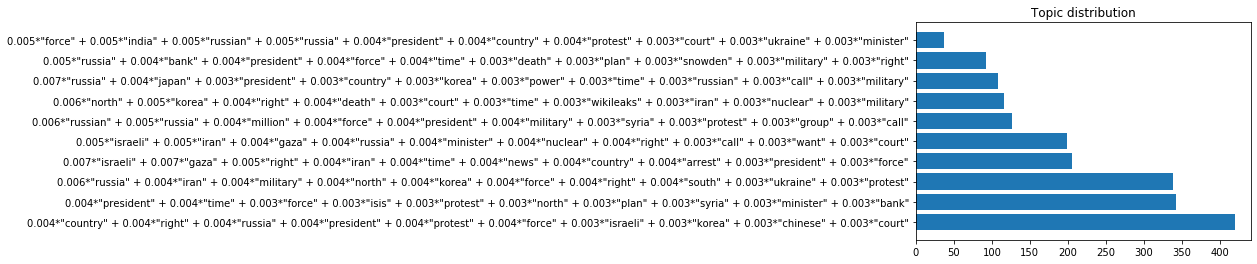

In [51]:
# What is the topic distribution?

names = single_topic['daily_words'].value_counts().index
values = single_topic['daily_words'].value_counts().values
plt.barh(names, values)
plt.yticks(names)
plt.title("Topic distribution")

In [45]:
# Export our improved LDA model
import joblib
joblib.dump(lda_model_bow, "lda_bow_improved.gz")

['lda_bow_improved.gz']